In [1]:
# Import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


    
"""결측값 처리"""

class MissingValueHandler:
    def __init__(self, dataframe):
        self.df = dataframe

    def fill_missing(self, column_name, method):
        column_data = self.df[column_name]  # 컬럼 데이터 가져오기
        
        if method == 'mean':
            return self.df[column_name].fillna(self.df[column_name].mean())
        elif method == 'median':
            return self.df[column_name].fillna(self.df[column_name].median())
        elif method == 'mode':
            return self.df[column_name].fillna(self.df[column_name].mode()[0])
        elif method == 'zero':
            return self.df[column_name].fillna(0)
        else:
            raise ValueError("지원하지 않는 방법입니다. 'mean', 'median', 'mode', 또는 'zero' 중에서 선택하세요.")

    def drop(self):
        self.df = self.df.dropna()  # 결측값 있는 행을 삭제
        return self.df

    def drop_loc(self):
        self.df = self.df.dropna(axis=1)  # 결측값 있는 열을 삭제
        return self.df

    def get_dataframe(self):
        return self.df  # 현재의 데이터프레임 반환



"""범주형 변수 인코딩" 또는 "레이블 인코딩"""

class CategoricalEncoder:
    def __init__(self, dataframe):
        from sklearn.preprocessing import LabelEncoder
        self.df = dataframe
        self.encoder = LabelEncoder()  # LabelEncoder 객체 생성

    def encode_labels(self):
        categorical_cols = self.df.select_dtypes(include=['object']).columns  # 범주형 열 선택

        for col in categorical_cols:
            self.df.loc[:, col] = self.encoder.fit_transform(self.df[col])  # .loc를 사용하여 열을 수정

        return self.df


"""스케일링""" 

def scale_data(df_encoded, method='StandardScaler'):
    # 예외 처리: 'StandardScaler' 또는 'MinMaxScaler' 외의 값이면 오류 발생
    if method == 'StandardScaler':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    elif method == 'MinMaxScaler':
        from sklearn.preprocessing import MinMaxScale
        scaler = MinMaxScaler()
    else:
        raise ValueError("method 파라미터는 'StandardScaler' 또는 'MinMaxScaler'이어야 합니다.")
    
    # 스케일링을 적용할 컬럼을 찾기
    columns_to_scale = []
    for col in df_encoded.columns:
        # 각 컬럼이 0과 1만 포함하는 경우는 스케일링하지 않음
        if not df_encoded[col].isin([0, 1]).all():
            columns_to_scale.append(col)
    
    # 스케일링할 컬럼만 따로 추출
    df_to_scale = df_encoded[columns_to_scale]
    
    # 해당 컬럼만 스케일링
    if not df_to_scale.empty:
        df_scaled = scaler.fit_transform(df_to_scale)
        df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale)
        
        # .loc을 사용하여 원본 DataFrame에 값을 안전하게 할당
        df_encoded.loc[:, columns_to_scale] = df_scaled
    
    return df_encoded



"""이상치 탐지 함수"""

def detect_outliers(ys, method='outliers_iqr'):
    if method == 'outliers_iqr':
        # IQR 방법
        quartile_1, quartile_3 = np.percentile(ys, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return np.where((ys > upper_bound) | (ys < lower_bound))
    
    elif method == 'outliers_z_score':
        # Z-Score 방법
        threshold = 3
        mean_y = np.mean(ys)
        stdev_y = np.std(ys)
        z_scores = [(y - mean_y) / stdev_y for y in ys]
        return np.where(np.abs(z_scores) > threshold)
    
    elif method == 'outliers_modified_z_score':
        # Modified Z-Score 방법
        threshold = 3.5
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                             for y in ys]
        return np.where(np.abs(modified_z_scores) > threshold)
    
    else:
        raise ValueError("잘못된 방법입니다. ['outliers_iqr', 'outliers_z_score', 'outliers_modified_z_score'] 중 하나를 선택해주세요.")


        



In [2]:
# 데이터셋 로드

df = pd.read_csv('Mall_Customers.csv')
df_filter = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# 결측값 확인
df_filter_check_missing = MissingValueHandler(df_filter)

#MVS.summarize(preprocessing=False)  # Before 상태
print("--- Describe of dtypes column ---")
print(df_filter.describe())
print("--- Sum of dtypes column ---")
print(df_filter_check_missing.df.dtypes)
print("--- Before Fill Missing ---")
print(df_filter_check_missing.df.isnull().sum())

--- Describe of dtypes column ---
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000
--- Sum of dtypes column ---
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
dtype: object
--- Before Fill Missing ---
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [3]:
# 결측값 처리
MVS = MissingValueHandler(df_filter)
#df_filter.loc[:, 'age'] = MVS.fill_missing('age', method='mean')
#df_filter.loc[:, 'embarked'] = MVS.fill_missing('embarked', method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')

#df_filter = MVS.drop()
#df_filter = MVS.drop_loc()

print("--- After Fill Missing ---")
print(df_filter.isnull().sum())

--- After Fill Missing ---
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [4]:
#라벨링
encoder = CategoricalEncoder(df_filter)
df_encoded = encoder.encode_labels()

print(df_encoded)

# 스케일화
df_scaled = scale_data(df_encoded, method='StandardScaler')
#df_scaled = scale_data(df_encoded, method='MinMaxScaler')

print(df_scaled)

     Age  Annual Income (k$)  Spending Score (1-100)
0     19                  15                      39
1     21                  15                      81
2     20                  16                       6
3     23                  16                      77
4     31                  17                      40
..   ...                 ...                     ...
195   35                 120                      79
196   45                 126                      28
197   32                 126                      74
198   32                 137                      18
199   30                 137                      83

[200 rows x 3 columns]
          Age  Annual Income (k$)  Spending Score (1-100)
0   -1.424569           -1.738999               -0.434801
1   -1.281035           -1.738999                1.195704
2   -1.352802           -1.700830               -1.715913
3   -1.137502           -1.700830                1.040418
4   -0.563369           -1.662660               -0

Initial number of rows before outlier removal: 200
Outlier values in the 'Age' column: Series([], Name: Age, dtype: float64)
Number of outliers detected in the 'Age' column: 0
Outlier values in the 'Annual Income (k$)' column: 198    2.917671
199    2.917671
Name: Annual Income (k$), dtype: float64
Number of outliers detected in the 'Annual Income (k$)' column: 2
Outlier values in the 'Spending Score (1-100)' column: Series([], Name: Spending Score (1-100), dtype: float64)
Number of outliers detected in the 'Spending Score (1-100)' column: 0
Final number of rows after outlier removal: 198

Dataframe after outlier removal:
          Age  Annual Income (k$)  Spending Score (1-100)
0   -1.424569           -1.738999               -0.434801
1   -1.281035           -1.738999                1.195704
2   -1.352802           -1.700830               -1.715913
3   -1.137502           -1.700830                1.040418
4   -0.563369           -1.662660               -0.395980
..        ...         

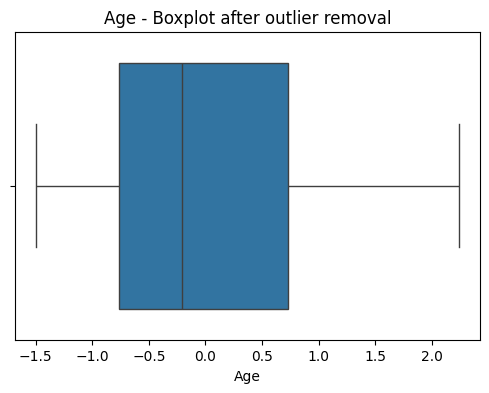

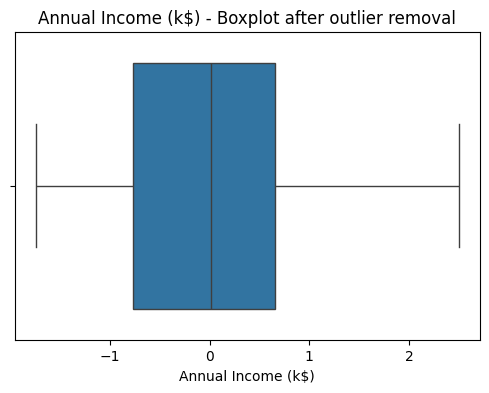

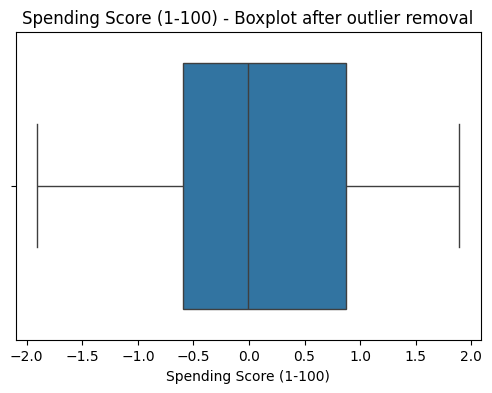


Comparison of row counts before and after outlier removal: 200 -> 198


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# IQR 기반 이상치 탐지 함수
outliers_model = 'outliers_iqr'
# outliers_model = 'outliers_z_score'
# outliers_model = 'outliers_modified_z_score' 

# 이상치 제거 전 데이터프레임의 행 수 저장
initial_row_count = df_scaled.shape[0]
print(f"Initial number of rows before outlier removal: {initial_row_count}")

# df_scaled는 이미 스케일링된 데이터프레임입니다
df_scaled_clean = df_scaled.copy()  # 이상치 제거 후 새로운 데이터프레임 저장

for column in df_scaled.columns:
    if df_scaled[column].dtype in ['int64', 'float64']:  # 숫자형 컬럼만 처리
        # 선택한 모델로 이상치 탐지
        outliers = detect_outliers(df_scaled[column], method=outliers_model)
        
        # 이상치 값 출력
        outlier_values = df_scaled[column].iloc[outliers[0]]
        print(f"Outlier values in the '{column}' column:", outlier_values)
        
        # 이상치 개수 출력
        print(f"Number of outliers detected in the '{column}' column:", len(outliers[0]))

        # 이상치 제거 (이상치가 있는 행을 제거)
        if len(outliers[0]) > 0:  # 이상치가 있을 때만 제거
            valid_outliers = [idx for idx in outliers[0] if idx in df_scaled.index]
            if valid_outliers:  # 유효한 이상치 인덱스만 제거
                df_scaled_clean = df_scaled_clean.drop(valid_outliers)

# 이상치 제거 후 데이터프레임의 행 수
final_row_count = df_scaled_clean.shape[0]
print(f"Final number of rows after outlier removal: {final_row_count}")

# 이상치 제거 후 데이터프레임 출력
print("\nDataframe after outlier removal:")
print(df_scaled_clean)

# 이상치 제거 후 각 컬럼에 대해 박스플롯 시각화
for column in df_scaled_clean.columns:
    if df_scaled_clean[column].dtype in ['int64', 'float64']:  # 숫자형 컬럼만 처리
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df_scaled_clean[column])
        plt.title(f'{column} - Boxplot after outlier removal')
        plt.show()

# 이상치 제거 전후 행 개수 비교 출력
print(f"\nComparison of row counts before and after outlier removal: {initial_row_count} -> {final_row_count}")


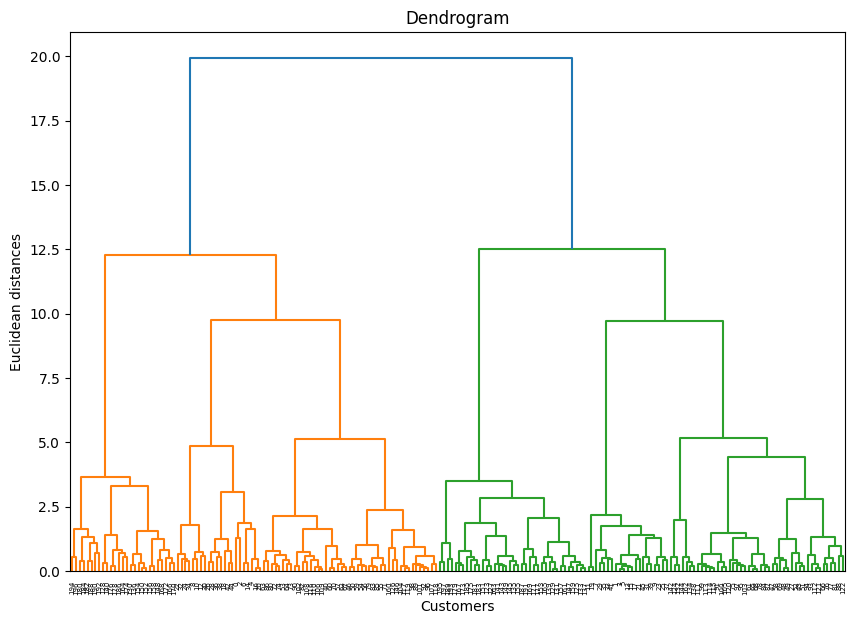

In [6]:
import scipy.cluster.hierarchy as sch

# 덴드로그램 생성
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(df_scaled_clean, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()


/home/pro/anaconda3/envs/Deep/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/pro/anaconda3/envs/Deep/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/pro/anaconda3/envs/Deep/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/pro/anaconda3/envs/Deep/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

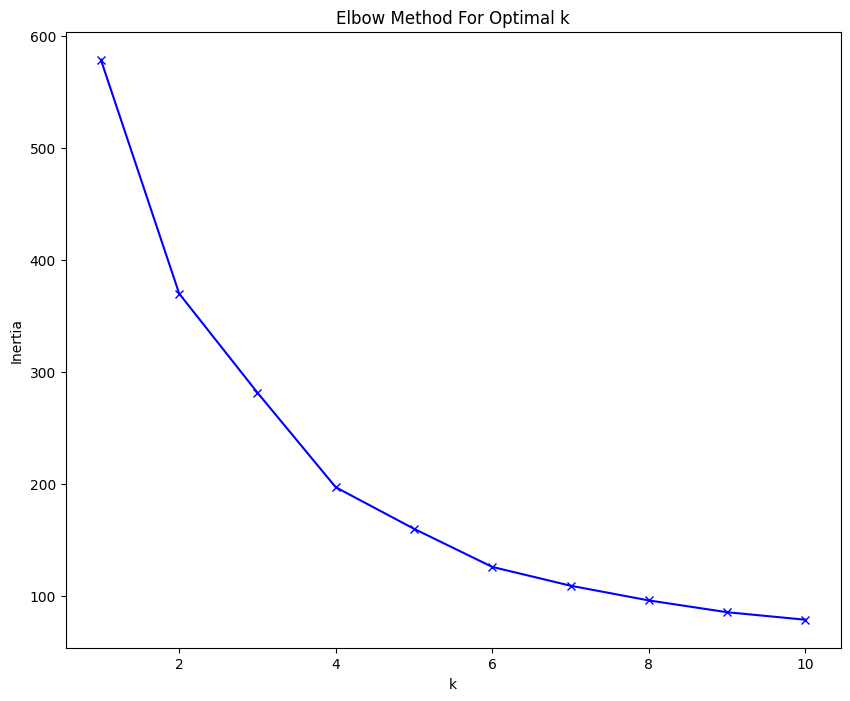

/home/pro/anaconda3/envs/Deep/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
from sklearn.cluster import KMeans

df_scaled = df_scaled_clean

# 최적의 k 찾기 (엘보우 방법)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(10, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# k=5로 모델 생성 및 학습
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_scaled)

# 군집 결과 할당
df_scaled['Cluster'] = kmeans.labels_

2


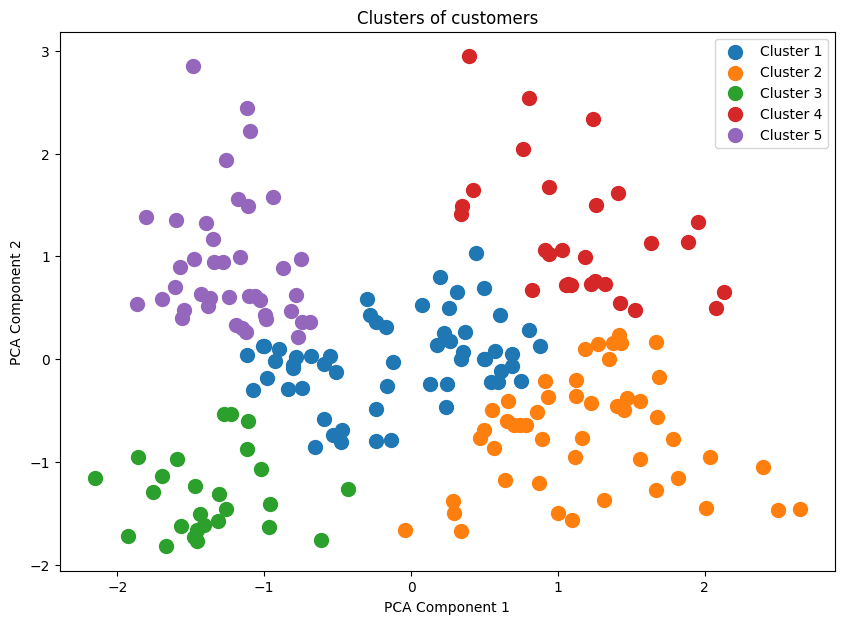

In [95]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df_scaled = df_scaled_clean

# 데이터의 특성 수 확인
n_features = df_scaled.shape[1]  # 데이터의 열(특성) 수
print(n_features)
n_components = 4  # 원하는 PCA 주성분 개수

# n_components가 데이터의 특성 개수를 넘지 않도록 자동으로 제한
n_components = min(n_components, n_features)

# PCA 모델 생성
pca = PCA(n_components=n_components)

# 훈련 데이터에 PCA 적용
df_scaled_pca = pca.fit_transform(df_scaled)

# 동적으로 columns 이름 생성
pca_columns = [f'PCA{i+1}' for i in range(n_components)]

# df_scaled_pca를 pandas DataFrame으로 변환
df_scaled_pca = pd.DataFrame(df_scaled_pca, columns=pca_columns)

# 계층적 군집화 모델 생성
model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

# 모델 학습 및 예측
y_hc = model.fit_predict(df_scaled_pca)

# 결과 시각화
plt.figure(figsize=(10, 7))

# 군집화된 결과를 시각화 (최대 5개 클러스터)
for i in range(5):
    if n_components >= 2:  # 2개 이상의 주성분이 있을 때 2D 시각화
        plt.scatter(df_scaled_pca.iloc[y_hc == i, 0], df_scaled_pca.iloc[y_hc == i, 1],
                    s=100, label=f'Cluster {i+1}')
    if n_components == 3:  # 3개 이상의 주성분이 있을 때 3D 시각화
        ax = plt.axes(projection='3d')
        ax.scatter(df_scaled_pca.iloc[y_hc == i, 0], df_scaled_pca.iloc[y_hc == i, 1], df_scaled_pca.iloc[y_hc == i, 2], s=100, label=f'Cluster {i+1}')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
    else:
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')

plt.title('Clusters of customers')
plt.legend()
plt.show()


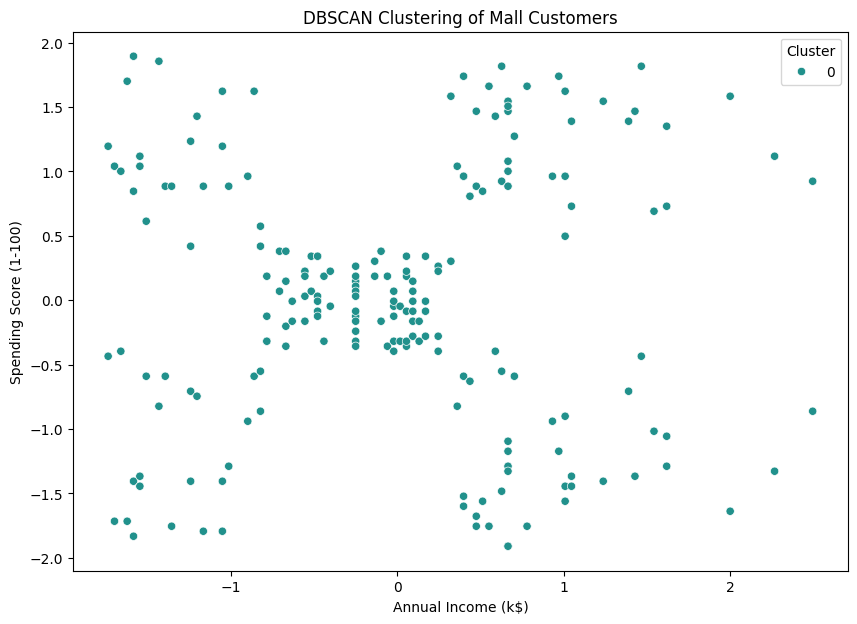

In [63]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# DBSCAN 모델 생성
model = DBSCAN(eps=5, min_samples=5)

# DBSCAN 클러스터링 수행
clusters = model.fit_predict(df_scaled)

# 클러스터링 결과를 df_scaled에 'Cluster' 열로 추가
df_scaled['Cluster'] = clusters

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df_scaled, palette='viridis')
plt.title('DBSCAN Clustering of Mall Customers')
plt.show()